# Data Engineering Capstone Project

#### Project Summary
The Organization for Tourism Development (OTD) want to analyze migration flux in USA, in order to find insights to significantly and sustainably develop the tourism in USA.

To support their core idea they have identified a set of analysis/queries they want to run on the raw data available.

The project deals with building a data pipeline, to go from raw data to the data insights on the migration flux.

The raw data are gathered from different sources, saved in files and made available for download.

Then saved into a temp s3 file to mimic cloud

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [ ]:
# Import the Pandas library for data analysis
import pandas as pd

# Import the re and os modules for regular expressions and operating system interfaces
import re
import os

# Import the matplotlib.pyplot module for data visualization
import matplotlib.pyplot as plt

# Import classes from the pyspark.sql module for working with PySpark DataFrames
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import col, sum as spark_sum
from pyspark.sql.types import *

import configparser

import boto3

### Step 1: Scope the Project and Gather Data

#### Scope 
- Explore and clean three data sets and one database. Then, break down the immigration database into smaller tables and load them into an S3 bucket.


#### Describe and Gather Data 

    1- I94 Immigration Data: This data comes from the US National Tourism and Trade Office.
    
    2- World Temperature Data: This dataset came from Kaggle.
    
    3- U.S. City Demographic Data: This data comes from OpenSoft.
    
    4- Airport Code Table: This is a simple table of airport codes and corresponding cities.

- The end solution is to upload the tables from immigration databse into s3.

- The tools is pyspark and AWS.



In [ ]:
# This code creates a new SparkSession with custom configuration options for reading SAS data and working with S3 data. 
# It also enables Hive support.
spark = SparkSession.builder\
    .config("spark.jars","https://repo1.maven.org/maven2/com/epam/parso/2.0.8/parso-2.0.8.jar,https://repos.spark-packages.org/saurfang/spark-sas7bdat/2.0.0-s_2.11/spark-sas7bdat-2.0.0-s_2.11.jar")\
    .config("spark.jars.packages","org.apache.hadoop:hadoop-aws:2.7.0")\
    .enableHiveSupport()\
    .getOrCreate()

In [ ]:
# Set the path to the immigration dataset
IMMIGRATION_DATASET_PATH = '../../data/18-83510-I94-Data-2016/'

# Get a list of all files in the dataset directory
filelist = os.listdir(IMMIGRATION_DATASET_PATH)

# Print the number of files in the dataset
print("The dataset contains {} files".format(len(filelist)))

In [ ]:
# Iterate over the list of files in the dataset directory
for file in filelist:
    # Print the name of the current file
    print(file)

### I94 Immigration Data

In [ ]:
# Construct the file path
file_path = '../../data/18-83510-I94-Data-2016/i94_dec16_sub.sas7bdat'
# Read the file using the com.github.saurfang.sas.spark format and persist it in memory
immigration_df = spark.read.format('com.github.saurfang.sas.spark').load(file_path).persist()

In [ ]:
# Access the first DataFrame
immigration_df.limit(5).toPandas().head()

In [ ]:
# Print the schema of the first PySpark DataFrame
immigration_df.printSchema()

In [ ]:
def transform_df(df):
    # Select all columns and add two new columns with the date conversions
    df = df.selectExpr("*", "to_date(dtadfile, 'yyyyMMdd') as added_date",
                       "to_date(dtaddto, 'MMddyyyy') as admission_date")
    
    @udf(returnType=DateType())
    def convert_to_datetime(date) -> DateType:
        """Convert timestamp to yyyy-mm-dd format."""
        if date is not None:
            return (pd.Timestamp("1960-1-1") + pd.to_timedelta(date, unit="D")).date()

    df = df.withColumn("arrival_date", convert_to_datetime(df["arrdate"])).distinct()
    df = df.withColumn("departure_date", convert_to_datetime(df["depdate"]))

    # Define a user-defined function to convert a column to integer type
    toInt = udf(lambda x: int(x) if x is not None else x, IntegerType())

    # Loop through the columns and their data types
    for colname, coltype in df.dtypes:
        # If the column data type is double
        if coltype == 'double':
            # Use the withColumn method to apply the toInt UDF to the column
            df = df.withColumn(colname, toInt(col(colname)))
    
    return df

In [ ]:
# Convert immigration_df in the data frame list
immigration_df = transform_df(immigration_df)

In [ ]:
immigration_df.printSchema()

### Temperature Data

In [ ]:
# This is file path
Temp_file_path = '../../data2/GlobalLandTemperaturesByCity.csv'
# Read the CSV file into a PySpark DataFrame
Temp_df = spark.read.csv(Temp_file_path, header=True, inferSchema=True)

In [ ]:
# Display the first 5 rows of the Temperature DataFrame
Temp_df.limit(5).toPandas().head(5)

In [ ]:
# Print the schema of the Temperature DataFrame
Temp_df.printSchema()

### U.S. City Demographic Data

In [ ]:
# Read the CSV file into a PySpark DataFrame
city_df = spark.read.option("header", True).options(delimiter=';').csv("us-cities-demographics.csv")

In [ ]:
# Display the first 5 rows of the city DataFrame
city_df.limit(5).toPandas().head(5)

In [ ]:
# Print the schema of the city DataFrame
city_df.printSchema()

In [ ]:
# Convert all numbers from string into numeric type
city_df = city_df.withColumn("Median Age", col("Median Age").cast("double"))
city_df = city_df.withColumn("Male Population", col("Male Population").cast("int"))
city_df = city_df.withColumn("Female Population", col("Female Population").cast("int"))
city_df = city_df.withColumn("Total Population", col("Total Population").cast("int"))
city_df = city_df.withColumn("Number of Veterans", col("Number of Veterans").cast("int"))
city_df = city_df.withColumn("Foreign-born", col("Foreign-born").cast("int"))
city_df = city_df.withColumn("Average Household Size", col("Average Household Size").cast("int"))
city_df = city_df.withColumn("Count", col("Count").cast("int"))

In [ ]:
# Print the schema of the city DataFrame
city_df.printSchema()

### Airport Code Table

In [ ]:
# Read the CSV file into a PySpark DataFrame
airport_codes_df = spark.read.csv('airport-codes_csv.csv', header=True, inferSchema=True)

In [ ]:
# Display the first 5 rows of the airport_codes DataFrame
airport_codes_df.limit(5).toPandas().head(5)

In [ ]:
# Print the schema of the airport_codes DataFrame
airport_codes_df.printSchema()

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

### Cleaning I94 Immigration Data

In [ ]:
# Counting the rows before cleaning
immigration_df.count()

In [ ]:
def clean_immigration_data(df):
    # Perform data cleaning steps here
    df = df.dropna(subset=['cicid'])
    # Drops duplicates
    df = df.dropDuplicates()
    return df

In [ ]:
# Clean immigration_df in the data frame list
immigration_df = clean_immigration_data(immigration_df)
immigration_df.write.format('parquet').mode('overwrite')

### cleaning Temperature Data 

In [ ]:
# Counting the rows before cleaning
Temp_df.count()

In [ ]:
def clean_temperature_data(Temp_df):
    # Drops duplicates 
    Temp_df = Temp_df.dropDuplicates() 
    
    # Drops the null values 
    Temp_df = Temp_df.dropna(subset=['dt']) 
    
    # Calculate the mean value of the "AverageTemperatureUncertainty" column 
    Uncertainty_mean = Temp_df.select(mean("AverageTemperatureUncertainty")).collect()[0][0] 
    # Fill missing values in the "AverageTemperatureUncertainty" column with the calculated mean value 
    Temp_df = Temp_df.na.fill(Uncertainty_mean, ["AverageTemperatureUncertainty"])
    
    # Calculate the mean value of the "AverageTemperature" column 
    Average_mean = Temp_df.select(mean("AverageTemperature")).collect()[0][0] 
    # Fill missing values in the "AverageTemperature" column with the calculated mean value 
    Temp_df = Temp_df.withColumn("AverageTemperature", when(col("AverageTemperature").isNull(), Average_mean).otherwise(col("AverageTemperature")))
    
    return Temp_df

In [ ]:
# See if there is any null values left
Temp_df.select([count(when(col(colname).isNull(),1)).alias(colname) for colname in Temp_df.columns]).toPandas().head()

In [ ]:
# Counting the rows after cleaning
Temp_df.count()

In [ ]:
# Folder simulating an S3 bucket
s3_temp = 'data/S3bucket_temp/clean_temp_data/'

In [ ]:
# Save to parquet
Temp_df.write.parquet(s3_temp, mode="overwrite")

### cleaning U.S. City Demographic Data

In [ ]:
# Counting the rows before cleaning
city_df.count()

In [ ]:
# Counting the null values for each row in the df
city_df.select([count(when(col(colname).isNull(),1)).alias(colname) for colname in city_df.columns]).toPandas().head()

In [ ]:
def clean_city_data(df):
    # Drops duplicates
    df = df.dropDuplicates()
    
    # Drops the null values
    df = df.dropna()

    df = df.withColumnRenamed("Median Age", "Median_Age")
    df = df.withColumnRenamed("Male Population", "Male_Population")
    df = df.withColumnRenamed("Female Population", "Female_Population")
    df = df.withColumnRenamed("Total Population", "Total_Population")
    df = df.withColumnRenamed("Number of Veterans", "Number_of_Veterans")
    df = df.withColumnRenamed("Foreign-born", "Foreign_born")
    df = df.withColumnRenamed("Average Household Size", "Average_Household_Size")
    df = df.withColumnRenamed("State Code", "State_Code")
    
    # Calculate the mean values of the columns
    Male_mean = df.select(mean("Male_Population")).collect()[0][0]
    Female_mean = df.select(mean("Female_Population")).collect()[0][0]
    Veterans_mean = df.select(mean("Number_of_Veterans")).collect()[0][0]
    Foreign_mean = df.select(mean("Foreign_born")).collect()[0][0]
    Household_mean = df.select(mean("Average_Household_Size")).collect()[0][0]

    # Fill missing values in the columns with the calculated mean values
    df = df.na.fill(Male_mean, ["Male_Population"])
    df = df.na.fill(Female_mean, ["Female_Population"])
    df = df.na.fill(Veterans_mean, ["Number_of_Veterans"])
    df = df.na.fill(Foreign_mean, ["Foreign_born"])
    df = df.na.fill(Household_mean, ["Average_Household_Size"])
    
    return df

In [ ]:
# Clean the data from the function
city_df = clean_city_data(city_df)

In [ ]:
# Counting the null values for each row in the df after cleaning
city_df.select([count(when(col(colname).isNull(),1)).alias(colname) for colname in city_df.columns]).toPandas().head()

In [ ]:
# Counting the rows after cleaning
city_df.count()

In [ ]:
# Folder simulating an S3 bucket
s3_city = 'data/S3bucket_temp/clean_city_data/'

In [ ]:
# Save to parquet
city_df.write.format('parquet').mode('overwrite').save(s3_city)

### Cleaning Airport Code Table

In [ ]:
# Counting the rows before cleaning
airport_codes_df.count()

In [ ]:
# Counting the null values for each row in the df before cleaning
airport_codes_df.select([count(when(col(colname).isNull(),1)).alias(colname) for colname in airport_codes_df.columns]).toPandas().head()

In [ ]:
def clean_airport_codes_data(df):
    # Drops duplicates
    df = df.dropDuplicates()
    
    # Drops the null values
    df = df.dropna()
    
    # Calculate the mean value of the column
    elevation_mean = df.select(mean("elevation_ft")).collect()[0][0]

    # Fill missing values in the column with the calculated mean value
    df = df.na.fill(elevation_mean, ["elevation_ft"])
    
    return df

In [ ]:
# Clean the data from the function
airport_codes_df = clean_airport_codes_data(airport_codes_df)

In [ ]:
# Counting the null values for each row in the df after cleaning
airport_codes_df.select([count(when(col(colname).isNull(),1)).alias(colname) for colname in airport_codes_df.columns]).toPandas().head()

In [ ]:
# Counting the rows after cleaning
airport_codes_df.count()

In [ ]:
# Folder simulating an S3 bucket
s3_airport = 'data/S3bucket_temp/clean_airport_data/'

In [ ]:
# Save to parquet
airport_codes_df.write.format('parquet').mode('overwrite').save(s3_airport)

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

#### The schema for fact and dimensional tables from immigration database


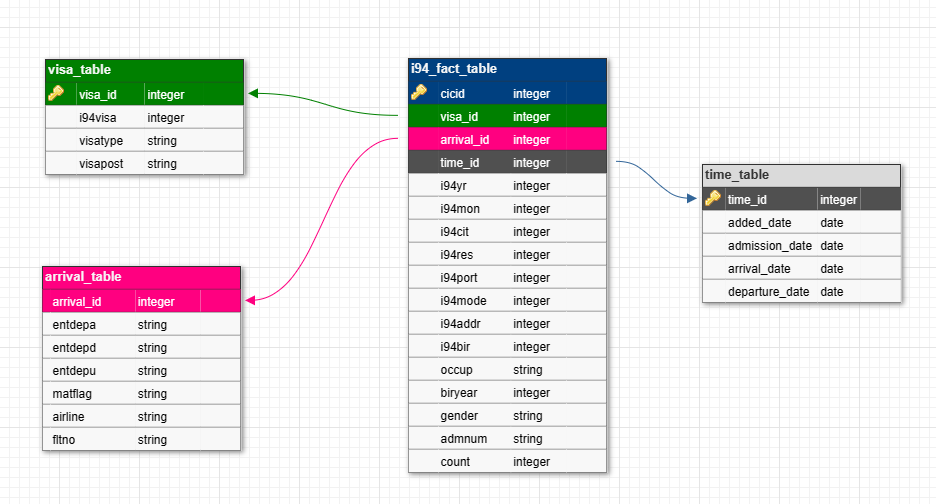

- I chose this model to simplify the table for user to get Querys from it easily.


#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

    dimentional tables:
        1- visa_table

        2- arrival_table 

        3- time_table 
     fact table: 
        - i94_fact_table
 

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [ ]:
# Reading credentials and configuration from file
config = configparser.ConfigParser()

config.read_file(open('config.cfg'))

KEY     = config['AWS']['AWS_ACCESS_KEY_ID']
SECRET  = config['AWS']['AWS_SECRET_ACCESS_KEY']

S3_BUCKET   = config['S3']['S3_bucket']

In [ ]:
s3 = boto3.resource('s3',
                    region_name="us-west-2",
                    aws_access_key_id     = KEY,
                    aws_secret_access_key = SECRET)

try:
    s3.create_bucket(Bucket=S3_BUCKET, CreateBucketConfiguration={
                    'LocationConstraint': 'us-west-2'})
except Exception as e:
    print(e)

In [ ]:
def process_immigration_data(df, output_data):
    
    # extract columns for visa table
    visa_table = df['i94visa', 'visatype', 'visapost']
    visa_table = visa_table.withColumn('visa_id', monotonically_increasing_id())
    # write visa table to parquet files
    visa_table.write.format('parquet').mode('overwrite').save(output_data)

    # extract columns for arrival table
    arrival_table = df['entdepa', 'entdepd', 'entdepu', 'matflag', 'airline', 'fltno']
    arrival_table = arrival_table.withColumn('arrival_id', monotonically_increasing_id())
    # write arrival table to parquet files
    arrival_table.write.format('parquet').mode('overwrite').save(output_data)

    # extract columns for time table
    time_table = df['added_date', 'admission_date', 'arrival_date', 'departure_date']
    time_table = time_table.withColumn('time_id', monotonically_increasing_id())
    # write time table to parquet files
    time_table.write.format('parquet').mode('overwrite').save(output_data)
    
    i94_fact_table = df['cicid', 'visa_id', 'flight_id', 'arrival_id', 'time_id',
                        'i94yr', 'i94mon', 'i94cit', 'i94res', 'i94port', 'i94mode',
                        'i94addr', 'i94bir', 'occup', 'biryear', 'gender', 'insnum','admnum', 'count']
    i94_fact_table.write.format('parquet').mode('overwrite').save(output_data)
    
    return visa_table, arrival_table, time_table, i94_fact_table
    

In [ ]:
output_data = "data/output/"
process_immigration_data(immigration_df, output_data)

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

- The query-in-place concept implemented here uses a very short pipeline, data are loaded from S3 and after a cleaning process are saved as parquet. Quality of the data is guaranteed by design.

In [ ]:
#Counting visa_table to ensure all rows inserted in it
visa_table.count()

In [56]:
result = spark.sql("SELECT * FROM visa_table")
result

In [ ]:
#checks quality for Temp_df
Temp_df.drop_duplicates().count() == Temp_df.count()

In [ ]:
#checks quality for city_df
city_df.drop_duplicates().count() == city_df.count()

In [ ]:
#checks quality for airport_codes_df
airport_codes_df.drop_duplicates().count() == airport_codes_df.count()

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### I94 Immigration Data:

cicid -> Unique record ID

i94yr -> 4 digit year

i94mon -> Numeric month

i94cit -> 3 digit code for immigrant country of birth

i94res -> 3 digit code for immigrant country of residence

i94port -> Port of admission

arrdate	-> Arrival Date in the USA

i94mode	-> Mode of transportation

i94addr	-> USA State of arrival

depdate	-> Departure Date from the USA

i94bir	-> Age of Respondent in Years

i94visa	-> Visa codes collapsed into three categories

count	-> Field used for summary statistics

dtadfile -> Character Date Field - Date added to I-94 Files

visapost ->Department of State where where Visa was issued

occup -> Occupation that will be performed in U.S

entdepa	-> Arrival Flag

entdepd	-> Departure Flag

entdepu	-> Update Flag

matflag	-> Match flag: arrival and departure records

biryear	-> 4 digit year of birth

dtaddto	-> Character Date Field

gender -> Non-immigrant sex

insnum -> INS number

airline	-> Airline used to arrive in U.S.

admnum	-> Admission Number

fltno -> Flight number of Airline used to arrive in U.S.

visatype -> Class of admission legally admitting to temporarily stay in U.S


----------------------------------------------------------------------------

#### Temperature Data:

dt -> Date

AverageTemperature -> Global average land temperature in celsius

AverageTemperatureUncertainty -> confidence interval around the average

City -> Name of City

Country -> Name of Country

Latitude -> City Latitude

Longitude -> City Longitude


-----------------------------------------------------------------------------


#### U.S. City Demographic Data:

City -> City Name

State -> US State where city is located

Median Age -> Median age of the population

Male Population	-> Count of male population

Female Population -> Count of female population

Total Population -> Count of total population

Number of Veterans -> Count of total Veterans

Foreign born -> Count of Foreign

Average Household Size -> Average city household size

State Code -> Code of the US state

Race -> Respondent race

Count -> Count of city's individual per race

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.

#### The data was increased by 100x.
- For such a scenario, I would consider using an Amazon EMR to run the ETL, and upload the data directly to the Amazon S3. Besides this, I would partition the tables. For example, I would partition the country_temperature_evolution table according to the country.

#### The data populates a dashboard that must be updated on a daily basis by 7am every day.
- For this situation, the ETL can be refactor to work with Apache Airflow, because it would be much easier to automate the execution of the pipeline.

#### The database needed to be accessed by 100+ people.
- If the database starts to be used intensively, I would consider moving the data to Amazon Redshift.